In [0]:
import numpy as np
np.set_printoptions(threshold=np.nan)

import time
import math
from sympy.geometry import Circle, Point
# import rospy
# from nav_msgs.msg import OccupancyGrid
# from std_msgs.msg import Float32
import matplotlib.pyplot as plt


# from visualization_msgs.msg import Marker
# from visualization_msgs.msg import MarkerArray
# from geometry_msgs.msg import Quaternion, Pose, Point, Vector3
# from std_msgs.msg import Header, ColorRGBA

# Vehicle Parameters
SPEED = 8
LENGTH = 4
WHEEL_BASE = 1.0
STEERING_RATIO = 1
vehicle_points = np.array([[-1.1, 2],[0, 2],[1.1, 2],[-1.1, 0],[0, 0],[1.1,0],[-1.1, -2],[0, -2],[1.1, -2]])


max_steering_rate = 0.0872665
left_limit_1 = 2.35619
left_limit_2 = 3.92699
right_limit_1 = 0.785398
right_limit_2 = -0.785398
max_angle = 0.785398
min_angle = -0.785398


### State Model

class state:

    def __init__(self, x, y, theta, g,f,h, steer):
        self.x = x
        self.y = y
        self.theta = theta
        self.g = g
        self.f = f
        self.h = h
        self.steer = steer


### State Transition

def transition(v_state, delta, dt, goal):
   
    # ---Begin Vehicle model---
    
    omega = SPEED/LENGTH * np.tan(delta)
    
    
    d_x = SPEED * np.cos(v_state.theta) * dt
    d_y = SPEED * np.sin(v_state.theta) * dt
    
    next_x = v_state.x + d_x
    
    next_y = v_state.y + d_y
   
    next_theta = normalize(v_state.theta + (omega*dt)) 

    # ---End Vehicle model---
    next_g = v_state.g + np.sqrt( d_x * d_x +  d_y * d_y )
    next_h = heuristic(next_x, next_y, goal)
    X = Goal.x-v_state.x 
    Y = Goal.y-v_state.y 
    angleInRadian = np.arctan2(Y,X)
    diff_theta = np.abs(angleInRadian - v_state.theta)
    #print("h",next_h)
    next_f = next_g + next_h + 0.1*(abs(delta))  + 0.1*(delta-v_state.steer) + diff_theta
    next_steer = delta

    # Create a new State object with all of the "next" values.
    new_state = state(next_x, next_y, next_theta, next_g, next_f, next_h, next_steer)

    return new_state


### Grid Resolution

grid_x_m = 40
grid_y_m = 40

coll_cell_side = 1.0
grid_coll_x = np.int( np.ceil(grid_x_m/coll_cell_side) )
grid_coll_y = np.int( np.ceil(grid_y_m/coll_cell_side) )

grid = np.zeros((grid_coll_x,grid_coll_y), np.int)

cell_side = 1.0
x_offset = (grid.shape[1]*coll_cell_side)/2
y_offset = (grid.shape[0]*coll_cell_side)/2




### Grid with Obstacles


### A Class to store  every  state and the index


class link:
    def __init__(self, inp_state, inp_index):
        self.state = inp_state
        self.index = inp_index
        


### Start And Goal

class start:

    def __init__(self, x, y, theta):
        self.x = x
        self.y = y
        self.theta = theta
        
class goal:

    def __init__(self, x, y):
        self.x = x
        self.y = y


### Helper Functions
def angle_between_two_points(x,y, goal):
    myradians = math.atan2(goal.y-y, goal.x-x)
    #print(myradians)
    return myradians

def lengthSquare(point1, point2):
    return (point1[0]-point2[0])**2 + (point1[1]-point2[1])**2




    
def get_angle(A, B, C):
    # Square of lengths be a2, b2, c2
    a2 = lengthSquare(B,C)
    b2 = lengthSquare(A,C)
    c2 = lengthSquare(A,B)

    # lenght of sides be a, b, c
    a = np.sqrt(a2)
    b = np.sqrt(b2)
    c = np.sqrt(c2)

    # From Cosine law
    alpha = np.cos((b2 + c2 - a2)/(2*b*c))
    beta = np.cos((a2 + c2 - b2)/(2*a*c))
    gamma = np.cos((a2 + b2 - c2)/(2*a*b))

        #// Converting to degree
#     alpha = alpha * 180 / np.pi
#     betta = betta * 180 / np.pi
#     gamma = gamma * 180 / np.pi

    return alpha, beta, gamma

def get_angle_special(A, B, C):
    # Square of lengths be a2, b2, c2
    a2 = lengthSquare(B,C)
    b2 = lengthSquare(A,C)
    c2 = lengthSquare(A,B)

    # lenght of sides be a, b, c
    a = np.sqrt(a2)
    b = np.sqrt(b2)
    c = np.sqrt(c2)

    # From Cosine law
    alpha = 6.28319 - np.cos((b2 + c2 - a2)/(2*b*c))
    beta = 6.28319 - np.cos((a2 + c2 - b2)/(2*a*c))
    gamma = 6.28319 - np.cos((a2 + b2 - c2)/(2*a*b))

        #// Converting to degree
#     alpha = alpha * 180 / np.pi
#     betta = betta * 180 / np.pi
#     gamma = gamma * 180 / np.pi

    return alpha, beta, gamma

def arclength(radius, beta):
    arc_length = radius * beta
    return arc_length
    

def deg_to_rad(delta):
    return delta * math.pi/180

def heuristic(x,y,goal):
    distance  = np.sqrt( ((x-goal.x)**2) + ((y-goal.y)**2) )
    return distance

def heuristic_2 (x,y,goal):
    angle_diff = angle_between_two_points(x,y, goal)     
    myradians = normalize_rad(angle_diff)
        
    
    #print(myradians)
    
    if myradians == 1.5707963267948966:
        total_distance = heuristic(x,y, goal)
        return total_distance
    
    
    elif ((deg_to_rad(90) < myradians< deg_to_rad(180))): 
        
        alpha_c,beta_c = -3.0, 0.0
        radius = 3.0
        print('1')
        target = [goal.x, goal.y]
        x2,y2,radius2 = mid_circle(alpha_c,beta_c,goal)            
        circle1 = [[alpha_c,beta_c],radius]
        circle2 = [[x2,y2], radius2]
        tangent_point = tang_from_point(circle1, circle2)
       
        alpha, beta, gamma = get_angle([x,y],[alpha_c,beta_c], tangent_point[0])
        distance_on_arc = arclength(radius, beta)
        distance_from_point = np.sqrt( ((target[0]-tangent_point[0][0])**2) + ((target[1]-tangent_point[0][1])**2) )
        total_distance = distance_on_arc + distance_from_point
        #print(total_distance ,distance_from_point,  distance_on_arc)
        return total_distance
        #print(heuristic_2 (x,y,delta,Goal))
        #distance_from_center = np.sqrt( ((target[0]-alpha_c)**2) + ((target[1]-beta_c)**2) )
            
    elif (deg_to_rad(0) <= myradians< deg_to_rad(90)):
        alpha_c,beta_c = 3.0, 0.0
        radius = 3.0
        print('2')
        target = [goal.x, goal.y]
        x2,y2,radius2 = mid_circle(alpha_c,beta_c,goal)            
        circle1 = [[alpha_c,beta_c],radius]
        circle2 = [[x2,y2], radius2]
        tangent_point = tang_from_point(circle1, circle2)
        alpha, beta, gamma = get_angle([x,y],[alpha_c,beta_c], tangent_point[0])
        distance_on_arc = arclength(radius, beta)
        distance_from_point = np.sqrt( ((target[0]-tangent_point[0][0])**2) + ((target[1]-tangent_point[0][1])**2) )
        total_distance = distance_on_arc + distance_from_point
        #print(total_distance ,distance_from_point,  distance_on_arc)
        return total_distance
    
    elif (deg_to_rad(180) <= myradians<= deg_to_rad(270)):
        alpha_c,beta_c = -3.0, 0.0
        radius = 3.0
        print('3')
        target = [goal.x, goal.y]
        x2,y2,radius2 = mid_circle(alpha_c,beta_c,goal)            
        circle1 = [[alpha_c,beta_c],radius]
        circle2 = [[x2,y2], radius2]
        tangent_point = tang_from_point(circle1, circle2)
        alpha, beta, gamma = get_angle_special([x,y],[alpha_c,beta_c], tangent_point[0])
        distance_on_arc = arclength(radius, beta)
        distance_from_point = np.sqrt( ((target[0]-tangent_point[0][0])**2) + ((target[1]-tangent_point[0][1])**2) )
        total_distance = distance_on_arc + distance_from_point
        #print(total_distance ,distance_from_point,  distance_on_arc)
        return total_distance
    
    elif (deg_to_rad(271) <= myradians< deg_to_rad(359)):
        alpha_c,beta_c = 3.0, 0.0
        radius = 3.0
        print('4')
        target = [goal.x, goal.y]
        x2,y2,radius2 = mid_circle(alpha_c,beta_c,goal)            
        circle1 = [[alpha_c,beta_c],radius]
        circle2 = [[x2,y2], radius2]
        tangent_point = tang_from_point(circle1, circle2)
        alpha, beta, gamma = get_angle_special([x,y],[alpha_c,beta_c], tangent_point[0])
        distance_on_arc = arclength(radius, beta)
        distance_from_point = np.sqrt( ((target[0]-tangent_point[0][0])**2) + ((target[1]-tangent_point[0][1])**2) )
        total_distance = distance_on_arc + distance_from_point
        #print(total_distance ,distance_from_point,  distance_on_arc)
        return total_distance
    
    
    

            
        
    



def normalize(theta):
    if theta < 0:    
        theta = theta + 2.0 * np.pi
        return theta
    if theta > 2*np.pi:    
        theta = theta - 2.0 * np.pi
        return theta
    else:
        return theta 

def normalize_rad(radians):
    if radians < 0:    
        radians = radians + 2.0 * np.pi
        return radians
    if radians > 2*np.pi:    
        radians = radians - 2.0 * np.pi
        return radians
    else:
        return radians 



def rotation(w,t):
    y = np.array([[np.cos(t), np.sin(t)], [-np.sin(t), np.cos(t)]])
    return np.matmul(w, y)
    

def transformation(w, x, y,t):
    p = np.zeros_like(w)
    for i in range(p.shape[0]):
        p[i][0:2] = w[i][0:2]+[x,y]
        
    return rotation(p,(t-np.pi/2))
    
def mid_circle(x,y,goal):
    x1 = x
    y1 = y
    radius = heuristic(x,y,goal)/2
    x2 = goal.x
    y2 = goal.y

    x_m_point = (x1 + x2)/2
    y_m_point = (y1 + y2)/2
    return (x_m_point, y_m_point, radius)

def tang_from_point(circle1, circle2): # circle = [[α, β], r] 

    x1,y1 = circle1[0][0], circle1[0][1]
    r1  = circle1[1] 
    x2,y2 = circle2[0][0], circle2[0][1]
    r2 = circle2[1]
    c1=Circle(Point(x1,y1),r1)
    c2=Circle(Point(x2,y2),r2)
    intersection = c1.intersection(c2)
    #print(len(intersection))
    if len(intersection) == 1:
        intersection.append(intersection[0])
    #print(intersection)
    p1 = intersection[0]
    p2 = intersection[1]
    xs1,ys1 = p1.x,p1.y
    xs2,ys2 = p2.x,p2.y
    return [(float(xs1),float(ys1)),(float(xs2),float(ys2))]


def get_grid_coordinates(x, y):
    x = x+x_offset
    y = y+y_offset
    cell_x = np.floor(x/cell_side)
    cell_y = np.floor(y/cell_side)
    #grid[cell_y, cell_x] = 2
    return cell_x, cell_y
    


def check_occupancy(x, y):
    x = x+x_offset
    y = y+y_offset
    cell_x = np.floor(x/coll_cell_side)
    cell_y = np.floor(y/coll_cell_side)
    #grid[cell_y, cell_x] = 2
    return grid[int(cell_y), int(cell_x)]


def delta_t(delta, n, off):

    delta_list = []
    delta_list.append(delta)
    delta_calc = delta
    for i in range(0 ,n):
        delta_calc += off   
        if delta_calc < max_angle:
            delta_list.append(delta_calc)
        
    delta_calc = delta
    for i in range(0 ,n):
        delta_calc -= off
        if min_angle < delta_calc:
            delta_list.append(delta_calc)
        
    return delta_list
  
  
def tangent(circle,point):
    cx = circle[0][0]
    cy = circle[0][1]
    radius = circle[1]
    px = point[0]
    py = point[1]
    distance = math.sqrt(( float(cx-px) **2 + float(cy-py)**2))
    #d=sqr((x1-x0)^2 + (y1-y0)^2)
    a=(r0^2-r1^2+d^2)/(2*d)
    h=sqr(r0^2-a^2)
    x2=x0+a*(x1-x0)/d   
    y2=y0+a*(y1-y0)/d   
    x3=x2+h*(y1-y0)/d       #// also x3=x2-h*(y1-y0)/d
    y3=y2-h*(x1-x0)/d       #// also y3=y2+h*(x1-x0)/d



def checkLimits( x,y ):
    
    result = True
    
    if  ( x < -grid_x_m/2 ) | ( y < -grid_y_m/2 ) | ( x > grid_x_m/2 ) | ( y > grid_y_m/2 ):
        
        result = False
    
    return result

state_cell_side = 1.0
grid_state_x = np.int( np.ceil(grid_x_m/state_cell_side) )
grid_state_y = np.int( np.ceil(grid_y_m/state_cell_side) )

NUM_THETA_CELLS = 360


x_state_offset = grid_x_m/2.0
y_state_offset = grid_y_m/2.0


def check_closed(x, y, theta):
    x = x + x_state_offset
    y = y + y_state_offset
    
    cell_x = np.floor(x/state_cell_side)
    cell_y = np.floor(y/state_cell_side)
    
    cell_theta = np.floor( theta * NUM_THETA_CELLS / (2.0 * np.pi) )
    return closed[int(cell_theta)][int(cell_y)][int(cell_x)]
    

def set_closed(x, y, theta):
    x = x + x_state_offset
    y = y + y_state_offset
    
    cell_x = np.floor(x/state_cell_side)
    cell_y = np.floor(y/state_cell_side)
    
    cell_theta = np.floor( theta * NUM_THETA_CELLS / (2.0 * np.pi) )
   
    closed[int(cell_theta)][int(cell_y)][int(cell_x)] = 1



  
# def listener():



#     rospy.Subscriber( "obstacle_grid", OccupancyGrid, callback, queue_size=1 )
#     rospy.Subscriber( "/currentSteerAngle", Float32, steerCallback )


#     rospy.spin()

# def search_service():

#     print( "Steer : ", search() )  

            
    


In [148]:
check_closed(1,1, 0.0)

0

In [140]:
grid

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [0]:
current_state = state(0.0, 0.0, deg_to_rad(0.0), 0.0, 0.0, 0.0, 0.0)
new_points = np.copy(vehicle_points)
#print(new_points)
Goal = goal( 0.0, 50.0 )


closed = [[[0 for x in range(grid_state_x)] for y in range(grid_state_y)] for cell in range(NUM_THETA_CELLS)]

path_state = current_state
open_list = []
path_link = link( path_state, 0 )
open_list.append( path_link )

trace_list = []
trace_link = link( path_state, -1 )
trace_list.append( trace_link )


path_x = []
path_y = []
path_h = []

path_x.append( current_state.x )
path_y.append( current_state.y )



In [0]:
def search():

#     topic = 'visualization_marker_array'
#     publisher = rospy.Publisher(topic, MarkerArray, queue_size=100)

#     markerArray = MarkerArray()


    goal_reached = 0
    grid_goal = 0
    counter = 0
    time_out = 45000
    low_h = 0
    low_index = 0
    for count in range(2):
        #start = time.time()
        while ( len(open_list) > 0 ) & (goal_reached == 0) & (counter<time_out) & (grid_goal ==0 ):
            
            counter+=1
            

            open_list.sort( key=lambda ste:float(ste.state.f) )

            #print("Pop Value",open_list[0].state.steer)
            path_link = open_list.pop(0)
            #print("The Steering angle:",path_link.state.steer)
            path_state = path_link.state
            #print(path_link.state.f, path_link.state.steer)
           # print(path_link.state.steer)
            path_index = path_link.index

           # print( "" )
            #print( "Best path")
            #print( path_state.x, path_state.y, path_state.theta, path_state.f )
            path_x.append( path_state.x )
            path_y.append( path_state.y )
           

            #exit = 0

            #while exit == 0:

            delta_angle = delta_t( path_state.steer, 4, 0.0872665 )

            #delta_angle = [ 30 * np.pi / 180, 60 * np.pi / 180, 0, -60 * np.pi / 180, -30 * np.pi / 180 ]

            #print( delta_angle )

            state_list = []

            for i in range(len(delta_angle)):
                
                new_state = transition( path_state, delta_angle[i], 0.1, Goal)
                
                #print( new_state.x, new_state.y, new_state.theta )
                
                if checkLimits( new_state.x , new_state.y ) == True:
                    if check_closed( new_state.x, new_state.y, new_state.theta ) == 0:                
                        state_list.append(new_state)
                        set_closed( new_state.x, new_state.y, new_state.theta )

                else:


                        X = Goal.x-new_state.x 
                        Y = Goal.y-new_state.y 
                        angleInRadian = np.arctan2(Y,X)

                        diff_theta = np.abs(angleInRadian - new_state.theta)
                        #print(diff_theta)
                        if diff_theta< 0.523599:
                            
                            grid_goal = 1
                            break
    
                        
            if grid_goal == 1 : 
                break
                    
    
                        
                        

            collision_free = []

            for i in range(len(state_list)):

                check = 0
                new_points = transformation(vehicle_points, state_list[i].x, state_list[i].y, state_list[i].theta)
                #new_points = [ [ state_list[i].x, state_list[i].y ] ]
                
                for point in new_points :
                    if checkLimits(point[0],point[1]) == True:

                        #get_x, get_y = get_grid_coordinates(point[0], point[1])
                        
                        check = check_occupancy(point[0], point[1])
                       
                    else :

                        X = Goal.x-state_list[i].x 
                        Y = Goal.y-state_list[i].y 
                        angleInRadian = np.arctan2(Y,X)

                        diff_theta = np.abs(angleInRadian - state_list[i].theta)
                        #print(diff_theta)
                        if diff_theta< 0.523599:
                            
                            grid_goal = 1
                            break
                        
                        check =1

                    if check == 1:
                    
                       break

                if check == 0:
                    collision_free.append(state_list[i])
                    

            if( collision_free ):

                for nstate in collision_free:
                    
                    #print( nstate.x, nstate.y, nstate.theta )
                    new_link = link( nstate, len(trace_list) )
                    open_list.append( new_link )
                    
                    
                    
                    trace_link = link( nstate, path_index )

                    trace_list.append( trace_link )
                    
                    if (low_h == 0) :
                        low_h =  nstate.h 
                        low_index = len(trace_list) - 1
                        
                    elif low_h > nstate.h:
                        low_h =  nstate.h 
                        low_index = len(trace_list) - 1
                                
                                
                                
                              
                    
                    if np.sqrt((nstate.x - Goal.x)**2 + (nstate.y - Goal.y)**2) < 0.5:
                        goal_reached = 1
                        path_x.append( nstate.x )
                        path_y.append( nstate.y )
                        print( "goal")
                        #end = time.time()
                        #print("Process Time", end - start)
            #print(len(trace_list))

            


    if goal_reached == 1 :
            fpath_x = []
            fpath_y = []
            fpath_steer = []
            
            curr_trace = trace_list[-1]
            
            while( curr_trace.index != -1 ):
                fpath_x.append( curr_trace.state.x )
                fpath_y.append( curr_trace.state.y )
                fpath_steer.append( curr_trace.state.steer )
                curr_trace = trace_list[ curr_trace.index ]
                
            plt.scatter( fpath_x, fpath_y)


            #print(fpath_x[-2], fpath_y[-2])

            #end = time.time()
            #print("Process Time", end - start)

            plt.axis( 'equal' )
            print('1')
            plt.show()
            plt.savefig('path.png')
            print(fpath_steer[-2])
            return fpath_steer[-2]



    if (goal_reached == 0) & (grid_goal ==0 ) :
            fpath_x = []
            fpath_y = []
            fpath_steer = []
            
            print("low_index:",low_index)
            curr_trace = trace_list[low_index]
            
            while( curr_trace.index != -1 ):
                fpath_x.append( curr_trace.state.x )
                fpath_y.append( curr_trace.state.y )
                fpath_steer.append( curr_trace.state.steer )
                curr_trace = trace_list[ curr_trace.index ]
                    
            plt.scatter( fpath_x, fpath_y)

            #print(fpath_x[-2], fpath_y[-2])
            

            plt.axis( 'equal' )
            print('2')
            plt.show()
            plt.savefig('path.png')
            #print(fpath_steer[-2])
            return fpath_steer[-2]


    if grid_goal == 1:
            #print("here")
            fpath_x = []
            fpath_y = []
            fpath_steer = []
            
            curr_trace = trace_list[path_index]
            
            while( curr_trace.index != -1 ):
                fpath_x.append( curr_trace.state.x )
                fpath_y.append( curr_trace.state.y )
                fpath_steer.append( curr_trace.state.steer )
                next_trace = curr_trace
                curr_trace = trace_list[ curr_trace.index ]
              
            plt.scatter( fpath_x, fpath_y )

            
            print(fpath_steer[-2])
            end = time.time()
            #print("Process Time", end - start)


            print('3')
            plt.axis( 'equal' )
            plt.show()
            plt.savefig('path.png')
            return fpath_steer[-2]
     
#     for i in range( len(fpath_x) ):
            
#             marker = Marker()
#             marker.header.frame_id = "/neck"
#             marker.id = i
#             marker.type = marker.SPHERE
#             marker.action = marker.ADD
#             marker.scale.x = 0.2
#             marker.scale.y = 0.2
#             marker.scale.z = 0.2
#             marker.color.a = 1.0
#             marker.color.r = 1.0
#             marker.color.g = 1.0
#             marker.color.b = 0.0
#             #marker.lifetime = rospy.Duration(0.5)
#             marker.pose.orientation.w = 1.0
#             marker.pose.position.x = fpath_x[i] + x_offset
#             marker.pose.position.y = fpath_y[i] + y_offset
#             marker.pose.position.z = 2

#             markerArray.markers.append(marker)

#     publisher.publish(markerArray)
    print(fpath_steer)
    return fpath_steer[-2]


# def steerCallback(msg):
#     current_state.steer = msg.data
    
# def callback(msg):

#     global grid

#     for i in range(grid.shape[0]):
#             for j in range(grid.shape[1]):
#                 grid[j,i] = msg.data[ grid.shape[0] * i + j ]

#     #print(grid_data)

#     f = open( "grid.csv", "w" )
  
#     for i in range(grid.shape[0]):
#             for j in range(grid.shape[1]):
#                 f.write( np.str( grid[i][j] ) )
#                 f.write( ", " )
#             f.write( "\n" )

#     f.close()
               
#     coll_cell_side =  msg.info.resolution

    

#     search_service()   


In [143]:
if __name__== "__main__":
    
    search()

IndexError: ignored

In [138]:
grid

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

[[-1.1  2. ]
 [ 0.   2. ]
 [ 1.1  2. ]
 [-1.1  0. ]
 [ 0.   0. ]
 [ 1.1  0. ]
 [-1.1 -2. ]
 [ 0.  -2. ]
 [ 1.1 -2. ]]


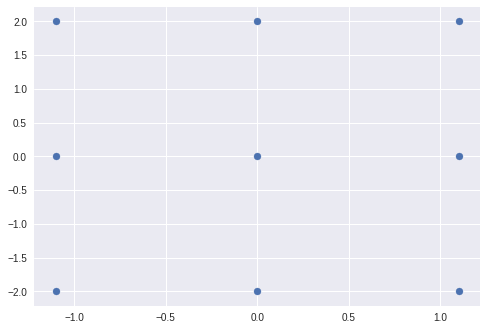

In [147]:
print( new_points )
px = []
py = []
for i in range(len(new_points)):
    px.append( new_points[i][0] )
    py.append( new_points[i][1] )

plt.scatter(px,py)
plt.show()